# Chicago Crime Data Analysis

In [1]:
from adjustText import adjust_text
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import (year, month, hour, minute, second, median, when,
                                    to_timestamp, date_format, col, udf, sum as spark_sum)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Preprocessing

In [2]:
spark = SparkSession.builder.appName("Chicago-Crime-Analysis").config("spark.driver.memory", "6g").getOrCreate()

spark

24/03/24 17:43:29 WARN Utils: Your hostname, RNR-Legion-Y7000P resolves to a loopback address: 127.0.1.1; using 192.168.21.152 instead (on interface enxc6a83ffe9a53)
24/03/24 17:43:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/24 17:43:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
chicago_crime_dataset_schema = StructType([
    StructField("ID", StringType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True ),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True  ),
    StructField("Description", StringType(), True ),
    StructField("Location Description", StringType(), True ),
    StructField("Arrest", BooleanType(), True),
    StructField("Domestic", BooleanType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", DoubleType(), True),
    StructField("Ward", DoubleType(), True),
    StructField("Community Area", DoubleType(), True),
    StructField("FBI Code", StringType(), True ),
    StructField("X Coordinate", DoubleType(), True),
    StructField("Y Coordinate", DoubleType(), True ),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", DateType(), True ),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True )
])


In [4]:
chicago_crime_dataset_path = "/home/rnr/study/cmpe255/Final Project/datasets/Crimes_-_2001_to_Present_20240313.csv"
spark_df = spark.read.csv(chicago_crime_dataset_path, header=True, schema=chicago_crime_dataset_schema)

spark_df

DataFrame[ID: string, Case Number: string, Date: string, Block: string, IUCR: string, Primary Type: string, Description: string, Location Description: string, Arrest: boolean, Domestic: boolean, Beat: string, District: double, Ward: double, Community Area: double, FBI Code: string, X Coordinate: double, Y Coordinate: double, Year: int, Updated On: date, Latitude: double, Longitude: double, Location: string]

In [5]:
# Dropping unnecessary columns

spark_df = spark_df.drop('ID')
spark_df = spark_df.drop('Case Number')
spark_df = spark_df.drop('FBI Code')
spark_df = spark_df.drop('Updated On')
spark_df = spark_df.drop('IUCR')
spark_df = spark_df.drop('Location')
spark_df = spark_df.drop('X Coordinate')
spark_df = spark_df.drop('Y Coordinate')
spark_df = spark_df.drop('Domestic')
spark_df = spark_df.drop('Beat')

spark_df.count()


8016560

In [6]:
# Remove duplicates from the DataFrame
spark_df = spark_df.dropDuplicates()
spark_df.count()

24/03/24 17:43:45 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


7996368

In [7]:
# Filter the dataframe to filter the records from 2013 - 2023
spark_df = spark_df.filter((spark_df['Year'] >= 2013) & (spark_df['Year'] <= 2023))
spark_df.count()

2834827

In [8]:
crime_primary_type = spark_df.groupby('Primary Type').count()
crime_primary_type.show(50)

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 24745|
|CRIMINAL SEXUAL A...|  7492|
|            STALKING|  2790|
|PUBLIC PEACE VIOL...| 17892|
|           OBSCENITY|   583|
|               ARSON|  4969|
|            GAMBLING|  2081|
|   CRIMINAL TRESPASS| 65378|
|             ASSAULT|212853|
|      NON - CRIMINAL|    38|
|LIQUOR LAW VIOLATION|  2783|
| MOTOR VEHICLE THEFT|145113|
|               THEFT|637216|
|             BATTERY|517921|
|             ROBBERY|108538|
|            HOMICIDE|  6791|
|    PUBLIC INDECENCY|   103|
| CRIM SEXUAL ASSAULT|  9279|
|   HUMAN TRAFFICKING|   101|
|        INTIMIDATION|  1691|
|        PROSTITUTION|  8343|
|  DECEPTIVE PRACTICE|193358|
|CONCEALED CARRY L...|  1220|
|         SEX OFFENSE| 12464|
|     CRIMINAL DAMAGE|308438|
|           NARCOTICS|163201|
|        NON-CRIMINAL|   175|
|       OTHER OFFENSE|177668|
|          KIDNAPPING|  1852|
|            BURGLARY|124469|
|   WEAPON

In [9]:
# Dropping rows where the count of Primary Type Crimes are very low 
spark_df = spark_df.filter(
     (spark_df['Primary Type']!='STALKING')&
     (spark_df['Primary Type']!='OBSCENITY')&
     (spark_df['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
     (spark_df['Primary Type']!='GAMBLING')&
     (spark_df['Primary Type']!='NON - CRIMINAL')&
     (spark_df['Primary Type']!='LIQUOR LAW VIOLATION')&
     (spark_df['Primary Type']!='PUBLIC INDECENCY')&
     (spark_df['Primary Type']!='HUMAN TRAFFICKING')&
     (spark_df['Primary Type']!='INTIMIDATION')&
     (spark_df['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
     (spark_df['Primary Type']!='NON-CRIMINAL')&
     (spark_df['Primary Type']!='OTHER NARCOTIC VIOLATION')&
    (spark_df['Primary Type']!='RITUALISM')
)

crime_primary_type = spark_df.groupby('Primary Type').count()
crime_primary_type.show(50)

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 24745|
|CRIMINAL SEXUAL A...|  7492|
|PUBLIC PEACE VIOL...| 17892|
|               ARSON|  4969|
|   CRIMINAL TRESPASS| 65378|
|             ASSAULT|212853|
| MOTOR VEHICLE THEFT|145113|
|               THEFT|637216|
|             BATTERY|517921|
|             ROBBERY|108538|
|            HOMICIDE|  6791|
| CRIM SEXUAL ASSAULT|  9279|
|        PROSTITUTION|  8343|
|  DECEPTIVE PRACTICE|193358|
|         SEX OFFENSE| 12464|
|     CRIMINAL DAMAGE|308438|
|           NARCOTICS|163201|
|       OTHER OFFENSE|177668|
|          KIDNAPPING|  1852|
|            BURGLARY|124469|
|   WEAPONS VIOLATION| 64412|
|INTERFERENCE WITH...| 10801|
+--------------------+------+



In [10]:
crime_location_description = spark_df.groupby('Location Description').count()
crime_location_description.show(100)

+--------------------+------+
|Location Description| count|
+--------------------+------+
|SCHOOL - PRIVATE ...|   938|
|VEHICLE - COMMERCIAL|   778|
|AIRPORT TERMINAL ...|  1879|
|RESIDENCE - YARD ...| 11021|
|               MOTEL|     3|
|POLICE FACILITY/V...|  6004|
|CHA PARKING LOT /...|  1690|
|            SIDEWALK|230451|
|AIRPORT TERMINAL ...|    94|
|OTHER RAILROAD PR...|   436|
|CTA GARAGE / OTHE...|  2840|
|            CAR WASH|  1342|
|    AIRPORT/AIRCRAFT|   632|
|    FEDERAL BUILDING|   423|
|MEDICAL/DENTAL OF...|  1962|
|         CTA STATION|  6975|
|SCHOOL, PUBLIC, G...|  8001|
|                FARM|     8|
|SPORTS ARENA/STADIUM|  1978|
|            CEMETARY|   160|
|               HOUSE|   291|
|VEHICLE - OTHER R...|   467|
|          VACANT LOT|    58|
|SCHOOL, PRIVATE, ...|  4149|
|TAVERN / LIQUOR S...|  1678|
|PARKING LOT / GAR...| 30472|
|            DRIVEWAY|    16|
|RESIDENCE - PORCH...| 12666|
|  VEHICLE-COMMERCIAL|  1713|
|     APPLIANCE STORE|  1009|
|         

In [11]:
# Dropping rows where the count of Location Description are less than 25

# Group by 'Location Description' and count occurrences
crime_location_description = spark_df.groupby('Location Description').count()

# Filter rows where count is >= 25
crime_location_description_filtered = crime_location_description.filter(F.col('count') >= 25)

# Join the filtered counts back to the original DataFrame
spark_df = spark_df.join(crime_location_description_filtered, on='Location Description', how='inner')

# Drop the count column (as it's no longer needed)
spark_df = spark_df.drop('count')

crime_location_description = spark_df.groupby('Location Description').count()
crime_location_description.show(100)

+--------------------+------+
|Location Description| count|
+--------------------+------+
|SCHOOL - PRIVATE ...|   938|
|VEHICLE - COMMERCIAL|   778|
|AIRPORT TERMINAL ...|  1879|
|RESIDENCE - YARD ...| 11021|
|POLICE FACILITY/V...|  6004|
|CHA PARKING LOT /...|  1690|
|            SIDEWALK|230451|
|AIRPORT TERMINAL ...|    94|
|OTHER RAILROAD PR...|   436|
|CTA GARAGE / OTHE...|  2840|
|            CAR WASH|  1342|
|    AIRPORT/AIRCRAFT|   632|
|    FEDERAL BUILDING|   423|
|MEDICAL/DENTAL OF...|  1962|
|         CTA STATION|  6975|
|SCHOOL, PUBLIC, G...|  8001|
|SPORTS ARENA/STADIUM|  1978|
|            CEMETARY|   160|
|               HOUSE|   291|
|VEHICLE - OTHER R...|   467|
|          VACANT LOT|    58|
|SCHOOL, PRIVATE, ...|  4149|
|TAVERN / LIQUOR S...|  1678|
|PARKING LOT / GAR...| 30472|
|RESIDENCE - PORCH...| 12666|
|  VEHICLE-COMMERCIAL|  1713|
|     APPLIANCE STORE|  1009|
|           WAREHOUSE|  2784|
|AIRPORT TERMINAL ...|  3332|
|AIRPORT EXTERIOR ...|   829|
|VEHICLE -

In [12]:
# Creating new columns for our Analysis
# Convert Date to timestamp
spark_df = spark_df.withColumn("timestamp", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a"))

# Extract day of the week and add it as a new column
spark_df = spark_df.withColumn("day_of_week", date_format("timestamp", "EEEE"))

# Extract month, hour and add it as a new column
spark_df = spark_df.withColumn("month", month("timestamp"))
spark_df = spark_df.withColumn("hour", hour("timestamp"))


spark_df.show(truncate=False)

+------------------------+----------------------+----------------------+--------------------------+------------------------------+------+--------+----+--------------+----+------------+-------------+-------------------+-----------+-----+----+
|Location Description    |Date                  |Block                 |Primary Type              |Description                   |Arrest|District|Ward|Community Area|Year|Latitude    |Longitude    |timestamp          |day_of_week|month|hour|
+------------------------+----------------------+----------------------+--------------------------+------------------------------+------+--------+----+--------------+----+------------+-------------+-------------------+-----------+-----+----+
|SCHOOL - PRIVATE GROUNDS|09/29/2023 08:00:00 AM|053XX S NATOMA AVE    |OTHER OFFENSE             |OTHER CRIME AGAINST PERSON    |false |8.0     |23.0|56.0          |2023|41.79516966 |-87.788000798|2023-09-29 08:00:00|Friday     |9    |8   |
|SCHOOL - PRIVATE GROUNDS|03/03/

In [13]:
# Creating new Column Community Area Name using Community Area Number

# Got this mapping from official chicago website
community_area_mapping = {
    1: "Rogers Park",
    2: "West Ridge",
    3: "Uptown",
    4: "Lincoln Square",
    5: "North Center",
    6: "Lake View",
    7: "Lincoln Park",
    8: "Near North Side",
    9: "Edison Park",
    10: "Norwood Park",
    11: "Jefferson Park",
    12: "Forest Glen",
    13: "North Park",
    14: "Albany Park",
    15: "Portage Park",
    16: "Irving Park",
    17: "Dunning",
    18: "Montclare",
    19: "Belmont Cragin",
    20: "Hermosa",
    21: "Avondale",
    22: "Logan Square",
    23: "Humboldt Park",
    24: "West Town",
    25: "Austin",
    26: "West Garfield Park",
    27: "East Garfield Park",
    28: "Near West Side",
    29: "North Lawndale",
    30: "South Lawndale",
    31: "Lower West Side",
    32: "Loop",
    33: "Near South Side",
    34: "Armour Square",
    35: "Douglas",
    36: "Oakland",
    37: "Fuller Park",
    38: "Grand Boulevard",
    39: "Kenwood",
    40: "Washington Park",
    41: "Hyde Park",
    42: "Woodlawn",
    43: "South Shore",
    44: "Chatham",
    45: "Avalon Park",
    46: "South Chicago",
    47: "Burnside",
    48: "Calumet Heights",
    49: "Roseland",
    50: "Pullman",
    51: "South Deering",
    52: "East Side",
    53: "West Pullman",
    54: "Riverdale",
    55: "Hegewisch",
    56: "Garfield Ridge",
    57: "Archer Heights",
    58: "Brighton Park",
    59: "McKinley Park",
    60: "Bridgeport",
    61: "New City",
    62: "West Elsdon",
    63: "Gage Park",
    64: "Clearing",
    65: "West Lawn",
    66: "Chicago Lawn",
    67: "West Englewood",
    68: "Englewood",
    69: "Greater Grand Crossing",
    70: "Ashburn",
    71: "Auburn Gresham",
    72: "Beverly",
    73: "Washington Heights",
    74: "Mount Greenwood",
    75: "Morgan Park",
    76: "O'Hare",
    77: "Edgewater"
}


# Define a UDF to map the community area number to its name
def map_community_area(number):
    return community_area_mapping.get(number, "Unknown")

# Register the UDF
map_community_area_udf = udf(map_community_area, StringType())

# Add a new column with the community area names
spark_df = spark_df.withColumn("Community Area Name", map_community_area_udf(spark_df["Community Area"]))

# Show the DataFrame with the new column
spark_df.show()


+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------------+----+------------+-------------+-------------------+-----------+-----+----+-------------------+
|Location Description|                Date|               Block|        Primary Type|         Description|Arrest|District|Ward|Community Area|Year|    Latitude|    Longitude|          timestamp|day_of_week|month|hour|Community Area Name|
+--------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------------+----+------------+-------------+-------------------+-----------+-----+----+-------------------+
|SCHOOL - PRIVATE ...|09/29/2023 08:00:...|  053XX S NATOMA AVE|       OTHER OFFENSE|OTHER CRIME AGAIN...| false|     8.0|23.0|          56.0|2023| 41.79516966|-87.788000798|2023-09-29 08:00:00|     Friday|    9|   8|     Garfield Ridge|
|SCHOOL - PRIVATE ...|03/03/2022 11:41:...|   02

# Handling Missing values

In [14]:
# Calculate the count of null values for each column
null_counts = spark_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in spark_df.columns])

# Show the count of null values for each column
null_counts.show()

+--------------------+----+-----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+
|Location Description|Date|Block|Primary Type|Description|Arrest|District|Ward|Community Area|Year|Latitude|Longitude|timestamp|day_of_week|month|hour|Community Area Name|
+--------------------+----+-----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+
|                   0|   0|    0|           0|          0|     0|       1|  53|             6|   0|   35231|    35231|        0|          0|    0|   0|                  0|
+--------------------+----+-----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+



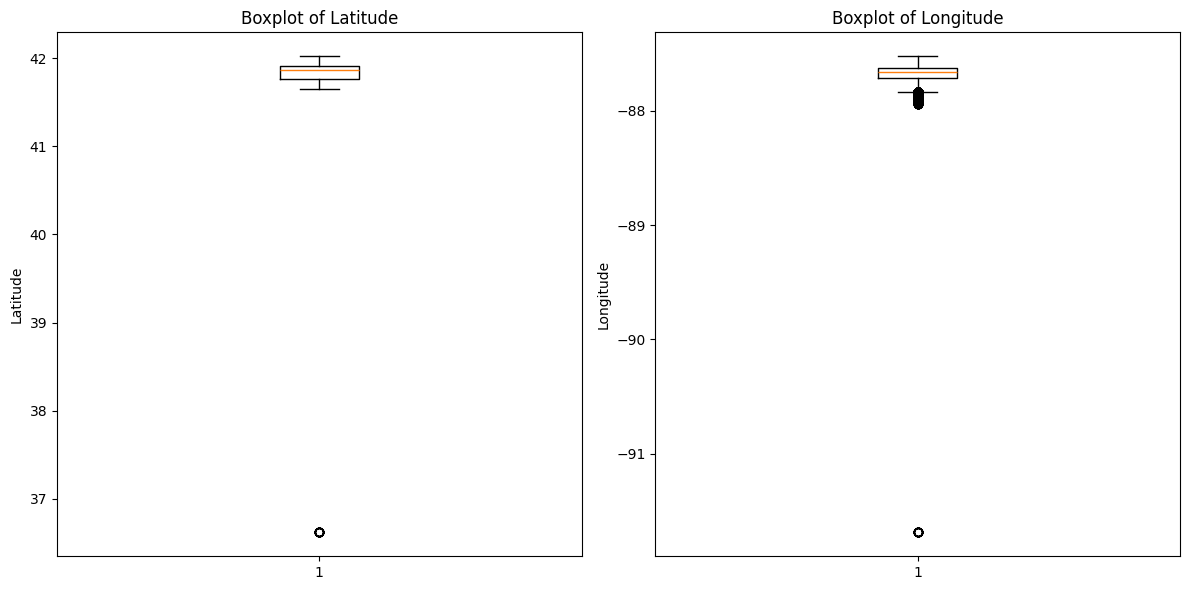

In [15]:
# Draw Box-Plots
filtered_spark_df = spark_df.filter((col("Latitude").isNotNull()) & (col("Longitude").isNotNull()))

# Collect data for boxplot
latitudes = filtered_spark_df.select("Latitude").rdd.flatMap(lambda x: x).collect()
longitudes = filtered_spark_df.select("Longitude").rdd.flatMap(lambda x: x).collect()

# Create subplots for Latitude and Longitude boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot Latitude boxplot
axes[0].boxplot(latitudes)
axes[0].set_title('Boxplot of Latitude')
axes[0].set_ylabel('Latitude')

# Plot Longitude boxplot
axes[1].boxplot(longitudes)
axes[1].set_title('Boxplot of Longitude')
axes[1].set_ylabel('Longitude')

# Show plot
plt.tight_layout()
plt.show()


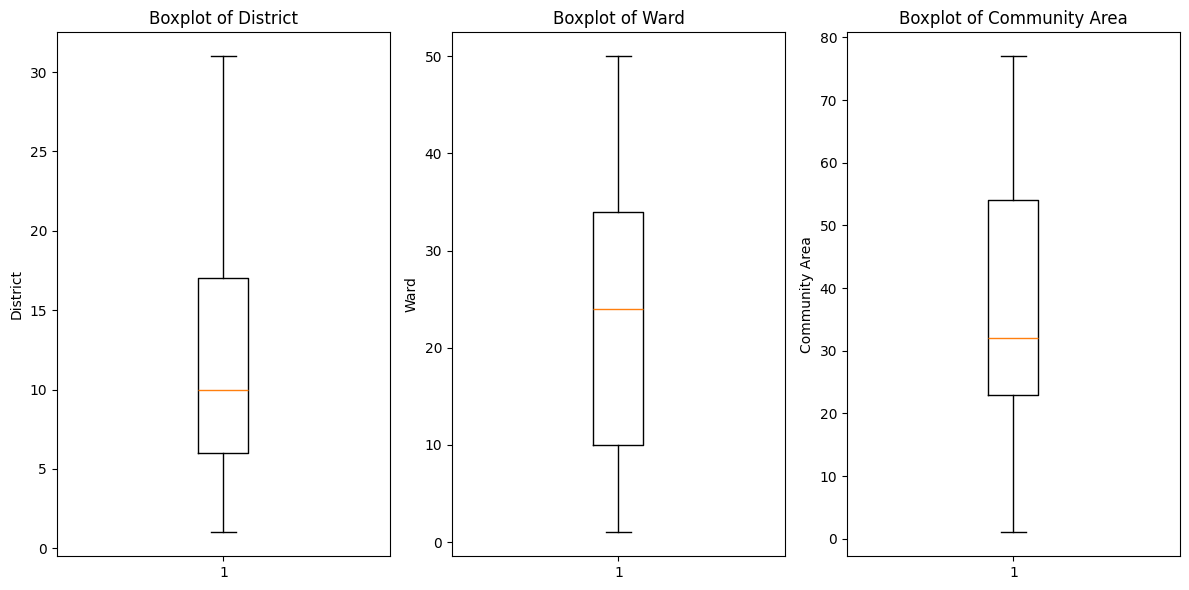

In [16]:
# Collect data for boxplot
filtered_spark_df = spark_df.filter(
    (col("District").isNotNull()) & (col("Ward").isNotNull()) & (col("Community Area").isNotNull()))

district = filtered_spark_df.select("District").rdd.flatMap(lambda x: x).collect()
ward = filtered_spark_df.select("Ward").rdd.flatMap(lambda x: x).collect()
community_area = filtered_spark_df.select("Community Area").rdd.flatMap(lambda x: x).collect()

# Create subplots for Latitude and Longitude boxplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Plot District boxplot
axes[0].boxplot(district)
axes[0].set_title('Boxplot of District')
axes[0].set_ylabel('District')

# Plot Ward boxplot
axes[1].boxplot(ward)
axes[1].set_title('Boxplot of Ward')
axes[1].set_ylabel('Ward')

# Plot Community Area boxplot
axes[2].boxplot(community_area)
axes[2].set_title('Boxplot of Community Area')
axes[2].set_ylabel('Community Area')

# Show plot
plt.tight_layout()
plt.show()

In [17]:
# Drop rows with missing Location Description values
spark_df = spark_df.filter(col("Location Description").isNotNull())

# Drop rows with missing District values
spark_df = spark_df.filter(col("District").isNotNull())

# Drop rows with missing Ward values
spark_df = spark_df.filter(col("Ward").isNotNull())

# Drop rows with missing Community Area values
spark_df = spark_df.filter(col("Community Area").isNotNull())

# Removing obvious Error values for Latitude and Longitude by looking at boxplot
spark_df = spark_df.filter((spark_df['Latitude'] >= 41) & (spark_df['Longitude'] >= -89))

# Handling Missing values for Latitude and Longitude by taking the median by considering Block column
# Group by Block and calculate median for Latitude and Longitude
block_median = spark_df.groupBy("Block").agg(
    median("Latitude").alias("median_latitude_block"),
    median("Longitude").alias("median_longitude_block")
)

# Join the median values back to the original DataFrame and fill missing values
spark_df = spark_df.join(block_median, on="Block", how="left")
spark_df = spark_df.withColumn("Latitude", 
                               when(col("Latitude").isNull(), col("median_latitude_block")).otherwise(col("Latitude")))
spark_df = spark_df.withColumn("Longitude", 
                               when(col("Longitude").isNull(), col("median_longitude_block")).otherwise(col("Longitude")))

# Drop the median columns
spark_df = spark_df.drop("median_latitude_block", "median_longitude_block")

# Show the count of null values for each column
null_counts = spark_df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in spark_df.columns])
null_counts.show()

+-----+--------------------+----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+
|Block|Location Description|Date|Primary Type|Description|Arrest|District|Ward|Community Area|Year|Latitude|Longitude|timestamp|day_of_week|month|hour|Community Area Name|
+-----+--------------------+----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+
|    0|                   0|   0|           0|          0|     0|       0|   0|             0|   0|       0|        0|        0|          0|    0|   0|                  0|
+-----+--------------------+----+------------+-----------+------+--------+----+--------------+----+--------+---------+---------+-----------+-----+----+-------------------+



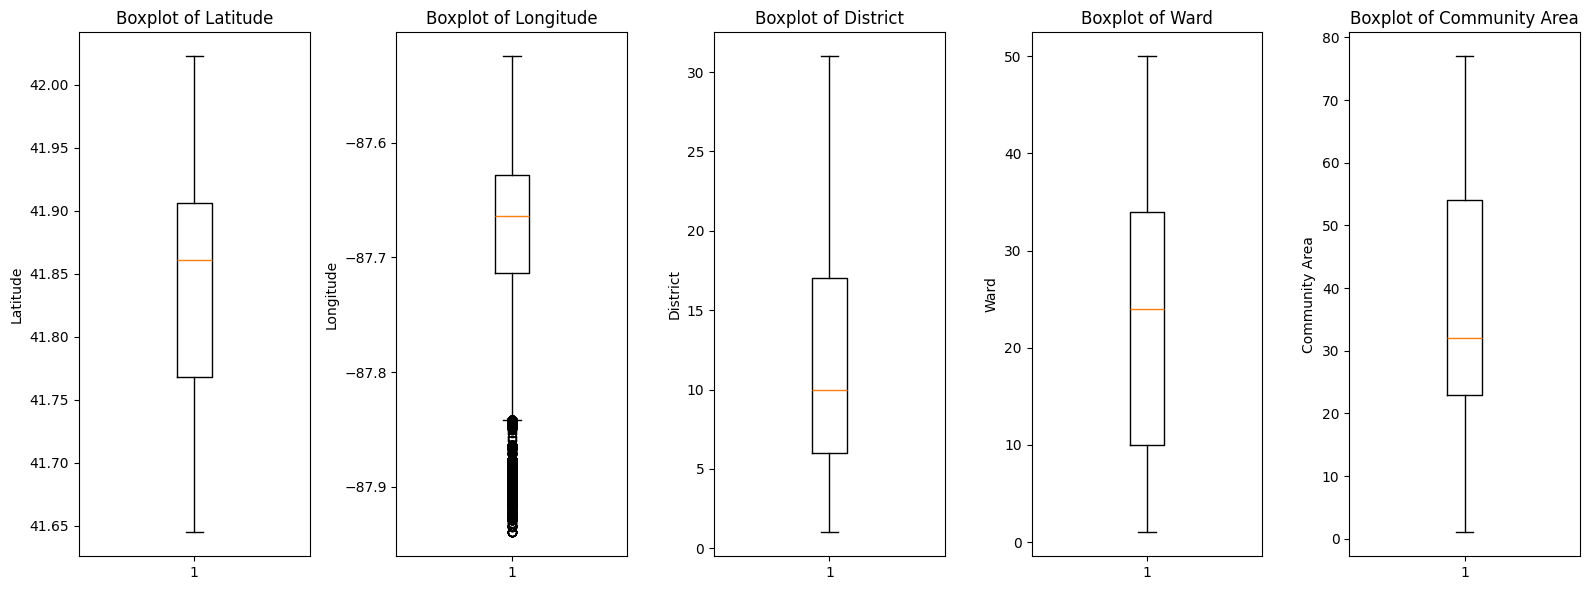

In [18]:
# Box-Plots after handling missing values

# Collect data for boxplot
latitudes = spark_df.select("Latitude").rdd.flatMap(lambda x: x).collect()
longitudes = spark_df.select("Longitude").rdd.flatMap(lambda x: x).collect()
district = spark_df.select("District").rdd.flatMap(lambda x: x).collect()
ward = spark_df.select("Ward").rdd.flatMap(lambda x: x).collect()
community_area = spark_df.select("Community Area").rdd.flatMap(lambda x: x).collect()
    
# Create subplots for Latitude and Longitude boxplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 6))

# Plot Latitude boxplot
axes[0].boxplot(latitudes)
axes[0].set_title('Boxplot of Latitude')
axes[0].set_ylabel('Latitude')

# Plot Longitude boxplot
axes[1].boxplot(longitudes)
axes[1].set_title('Boxplot of Longitude')
axes[1].set_ylabel('Longitude')

# Plot District boxplot
axes[2].boxplot(district)
axes[2].set_title('Boxplot of District')
axes[2].set_ylabel('District')

# Plot Ward boxplot
axes[3].boxplot(ward)
axes[3].set_title('Boxplot of Ward')
axes[3].set_ylabel('Ward')

# Plot Community Area boxplot
axes[4].boxplot(community_area)
axes[4].set_title('Boxplot of Community Area')
axes[4].set_ylabel('Community Area')

# Show plot
plt.tight_layout()
plt.show()

# Visualization

# Total Number of Crimes Over Time in Chicago
The line plot illustrates the total number of crimes over time in Chicago. There seem to be some fluctuations and potentially some trends or patterns that could be worth exploring further, for example The Q1 crimes are low and it gradually increases in Q2 and Q3 and decreases again in Q4. It is worth noting that the crimes are less during Pandemic time (2020 - 2022).

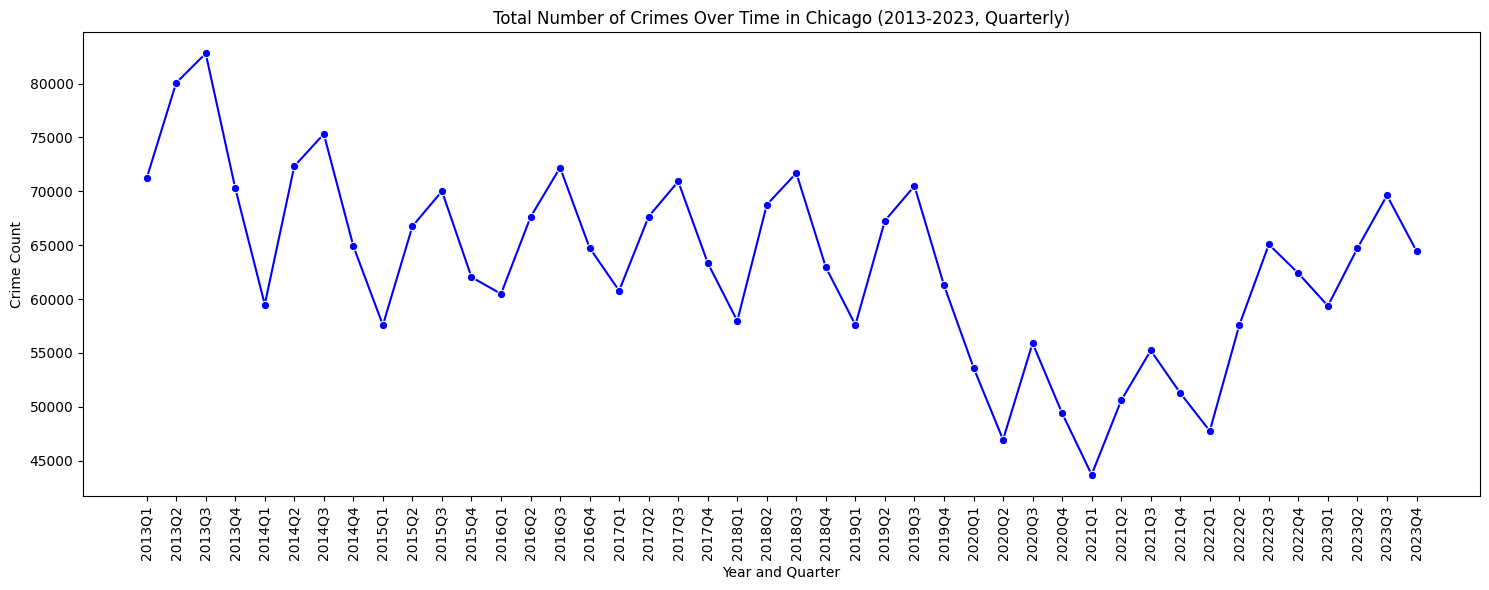

In [19]:
# Extract year and quarter from 'timestamp' column
spark_df = spark_df.withColumn('year_quarter', F.concat(F.year('timestamp'), F.lit('Q'), F.quarter('timestamp')))

# Group by 'year_quarter' and count rows
crime_counts = spark_df.groupBy('year_quarter').agg(F.count('*').alias('crimes_count')).orderBy('year_quarter')

# Convert Spark DataFrame to Pandas DataFrame for plotting
crime_counts_pd = crime_counts.toPandas()

# Visualize the trend of crimes over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='year_quarter', y='crimes_count', data=crime_counts_pd, marker='o', color='b')
plt.title('Total Number of Crimes Over Time in Chicago (2013-2023, Quarterly)')
plt.xlabel('Year and Quarter')
plt.ylabel('Crime Count')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()


# Frequency of Top 10 Crime Types by Area in Chicago
The heatmap provides a detailed view of how the top 10 crime types are distributed across different areas in Chicago. The color intensity indicates the frequency of each crime type within an area, allowing us to quickly identify which crimes are most prevalent in which areas. This kind of visualization can be particularly useful for law enforcement to target specific crime types in areas where they are most common.

24/03/24 17:53:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


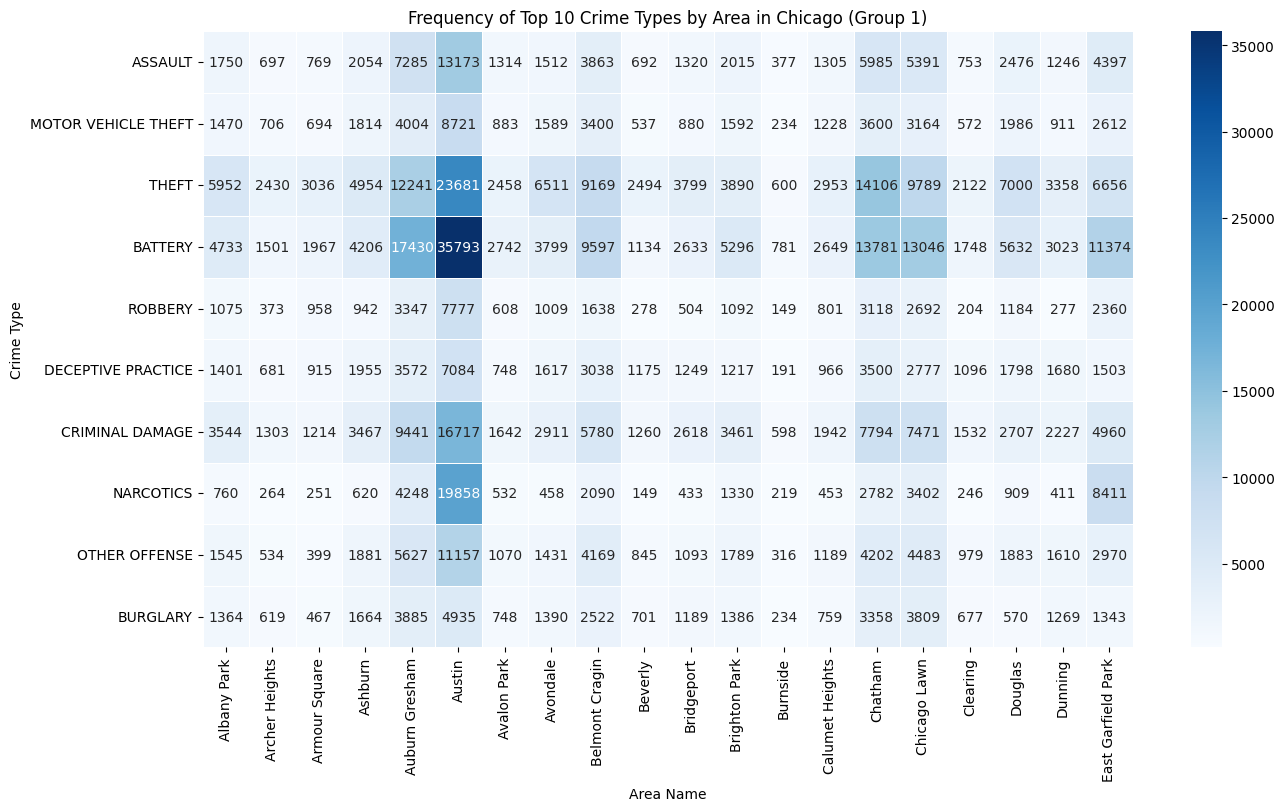

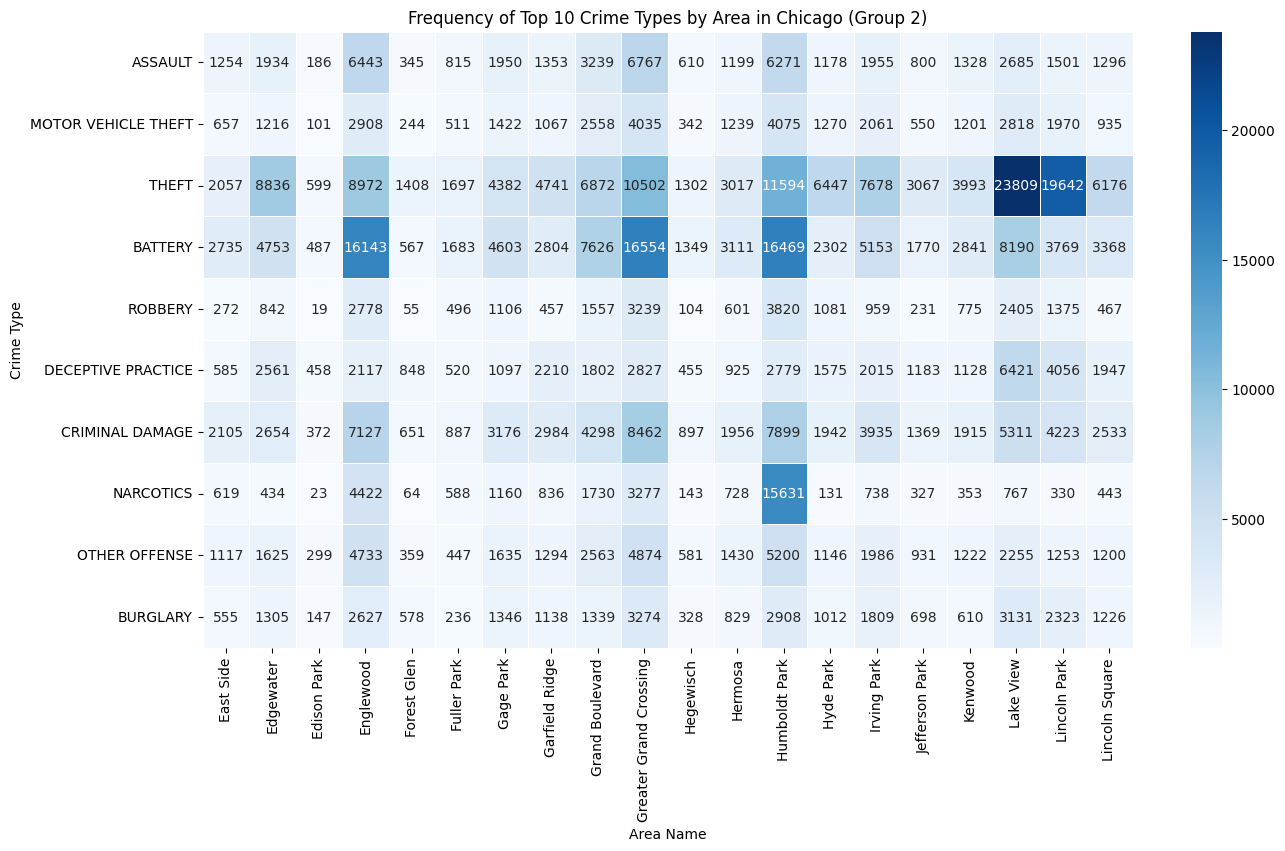

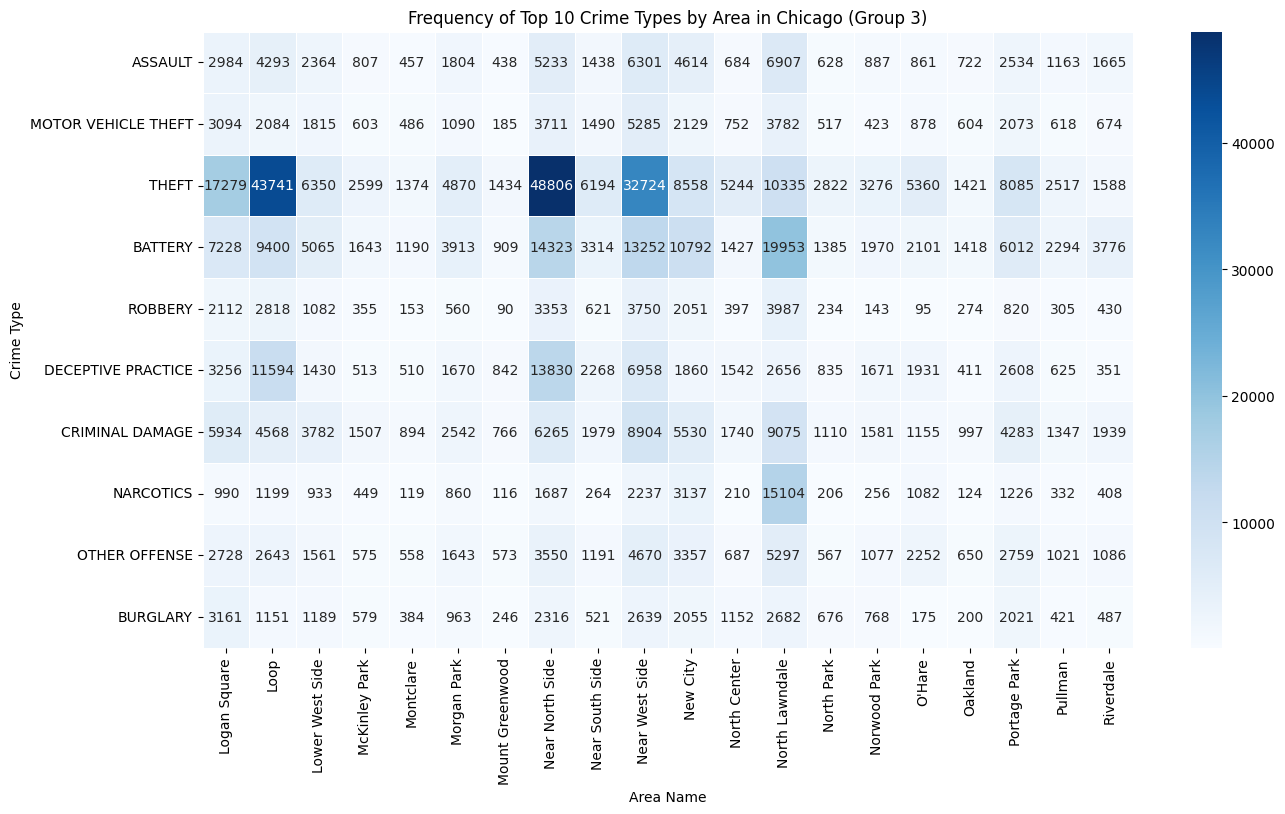

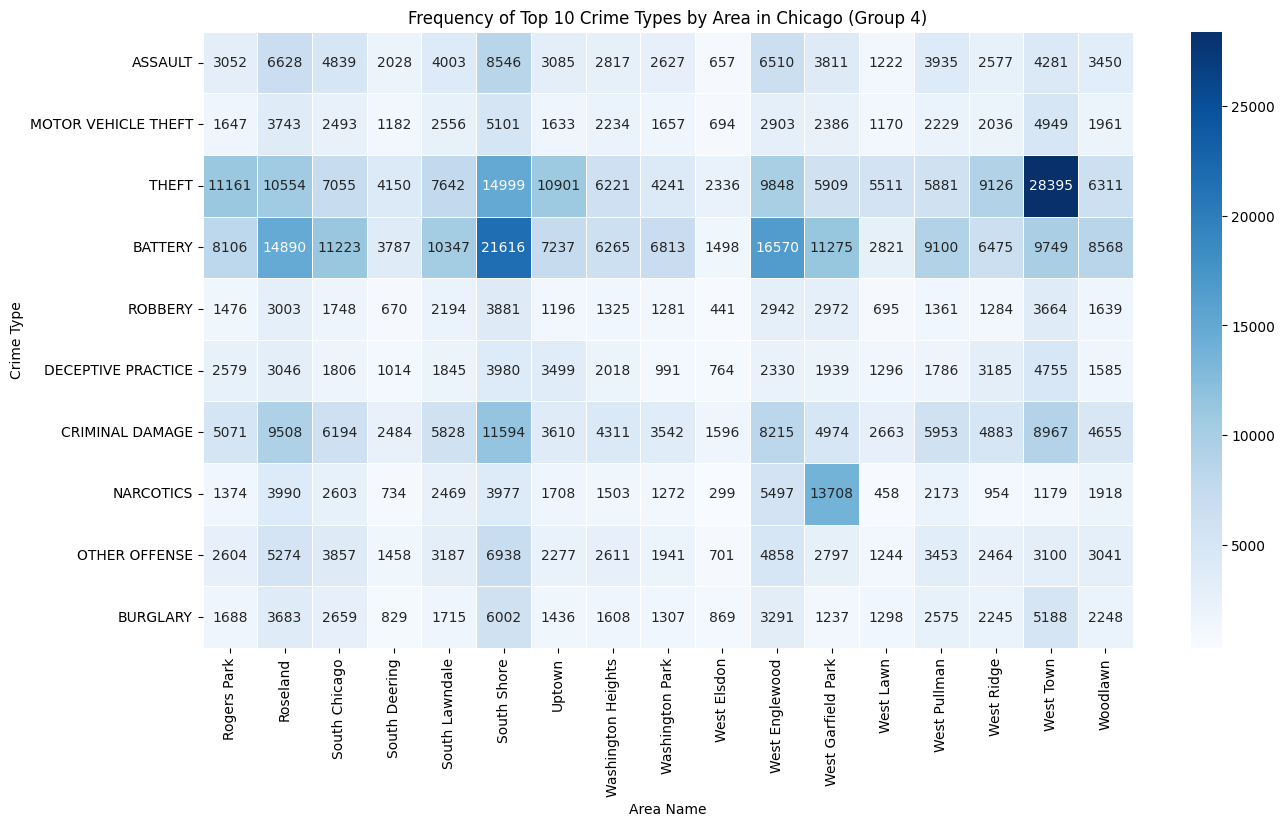

In [20]:
# Get the top 10 crime types
crime_type_counts = spark_df.groupBy('Primary Type').count().orderBy('count', ascending=False).limit(10)
top_crimes = [row['Primary Type'] for row in crime_type_counts.collect()]

# Filter the dataset for the top 10 crime types
top_crimes_data = spark_df.filter(spark_df['Primary Type'].isin(top_crimes))

# Create a pivot table for the heatmap
crime_type_area_pivot = top_crimes_data.groupBy('Primary Type', 'Community Area Name').count() \
                                        .groupBy('Primary Type').pivot('Community Area Name').sum('count') \
                                        .na.fill(0)

# Convert Spark DataFrame to Pandas DataFrame
crime_type_area_pivot_pd = crime_type_area_pivot.toPandas()

# Divide the areas into four groups
num_areas = len(crime_type_area_pivot_pd.columns) - 1  # Subtract 1 for the 'Description' column
num_areas_per_group = 20
num_groups = (num_areas + num_areas_per_group - 1) // num_areas_per_group

# Plot each group separately
for i in range(num_groups):
    start_idx = i * num_areas_per_group
    end_idx = min((i + 1) * num_areas_per_group, num_areas)
    group_areas = crime_type_area_pivot_pd.columns[1:][start_idx:end_idx]
    
    # Select the subset of areas for this group
    group_df = crime_type_area_pivot_pd[['Primary Type'] + list(group_areas)]
    
    # Plot the heatmap for this group
    plt.figure(figsize=(15, 8))
    sns.heatmap(group_df.set_index('Primary Type'), annot=True, fmt="d", cmap='Blues', linewidths=.5)
    plt.title(f'Frequency of Top 10 Crime Types by Area in Chicago (Group {i+1})')
    plt.xlabel('Area Name')
    plt.ylabel('Crime Type')
    plt.xticks(rotation=90)
    plt.show()

# Top 10 Most Common Crime Types in Chicago
This visualization provides a clear picture of which types of crimes are most frequently reported. Understanding the prevalence of different crime types can help in prioritizing and strategizing crime prevention and response efforts.

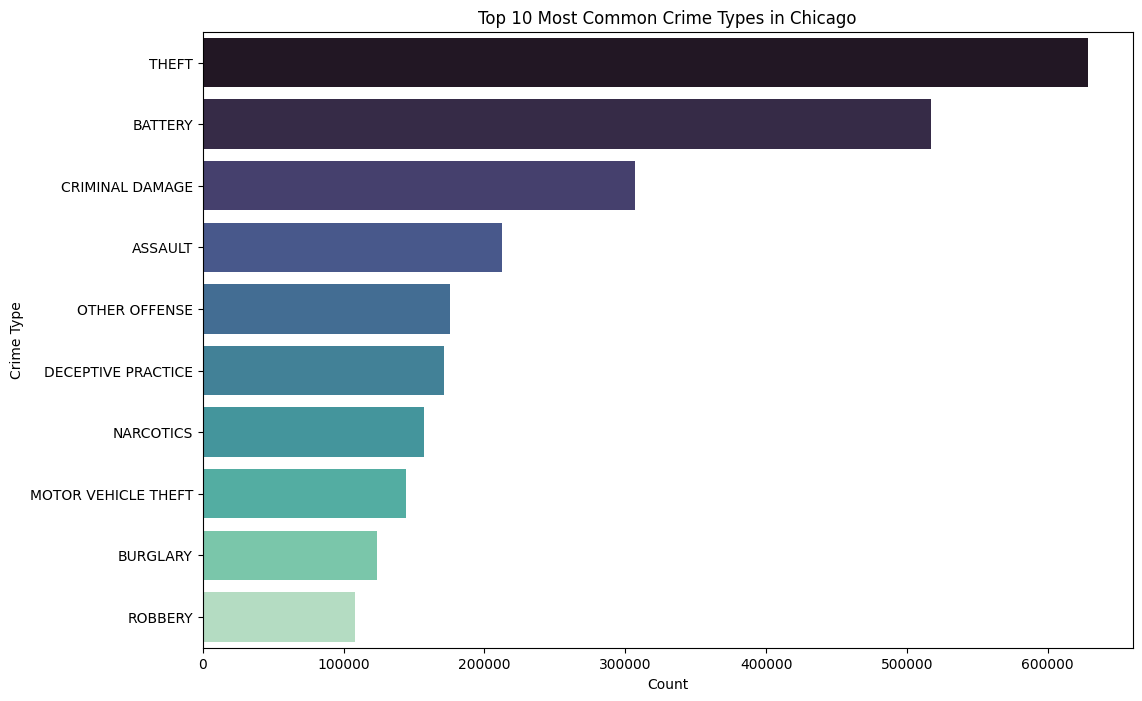

In [21]:
# Group by 'Primary Type' and count the number of each type of crime
crime_type_counts = spark_df.groupBy('Primary Type').count().orderBy(F.desc('count')).limit(10)

# Convert the result to Pandas DataFrame for plotting
crime_type_counts_pd = crime_type_counts.toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='Primary Type', data=crime_type_counts_pd, hue='Primary Type', palette='mako', legend=False)
plt.title('Top 10 Most Common Crime Types in Chicago')
plt.xlabel('Count')
plt.ylabel('Crime Type')
plt.show()

# Trends of Top 10 Crime Types Over Time in Chicago
The line plot illustrates the trends of the top 10 crime types over time in Chicago. Each line represents the frequency of a specific crime type from month to month. This visualization helps us identify patterns, such as increases or decreases in crime rates, and any seasonal trends or anomalies.

From the plot, we can observe that some crime types show clear trends, while others fluctuate more randomly. This kind of analysis can be particularly insightful for predicting future crime rates and understanding the effectiveness of law enforcement strategies over time.

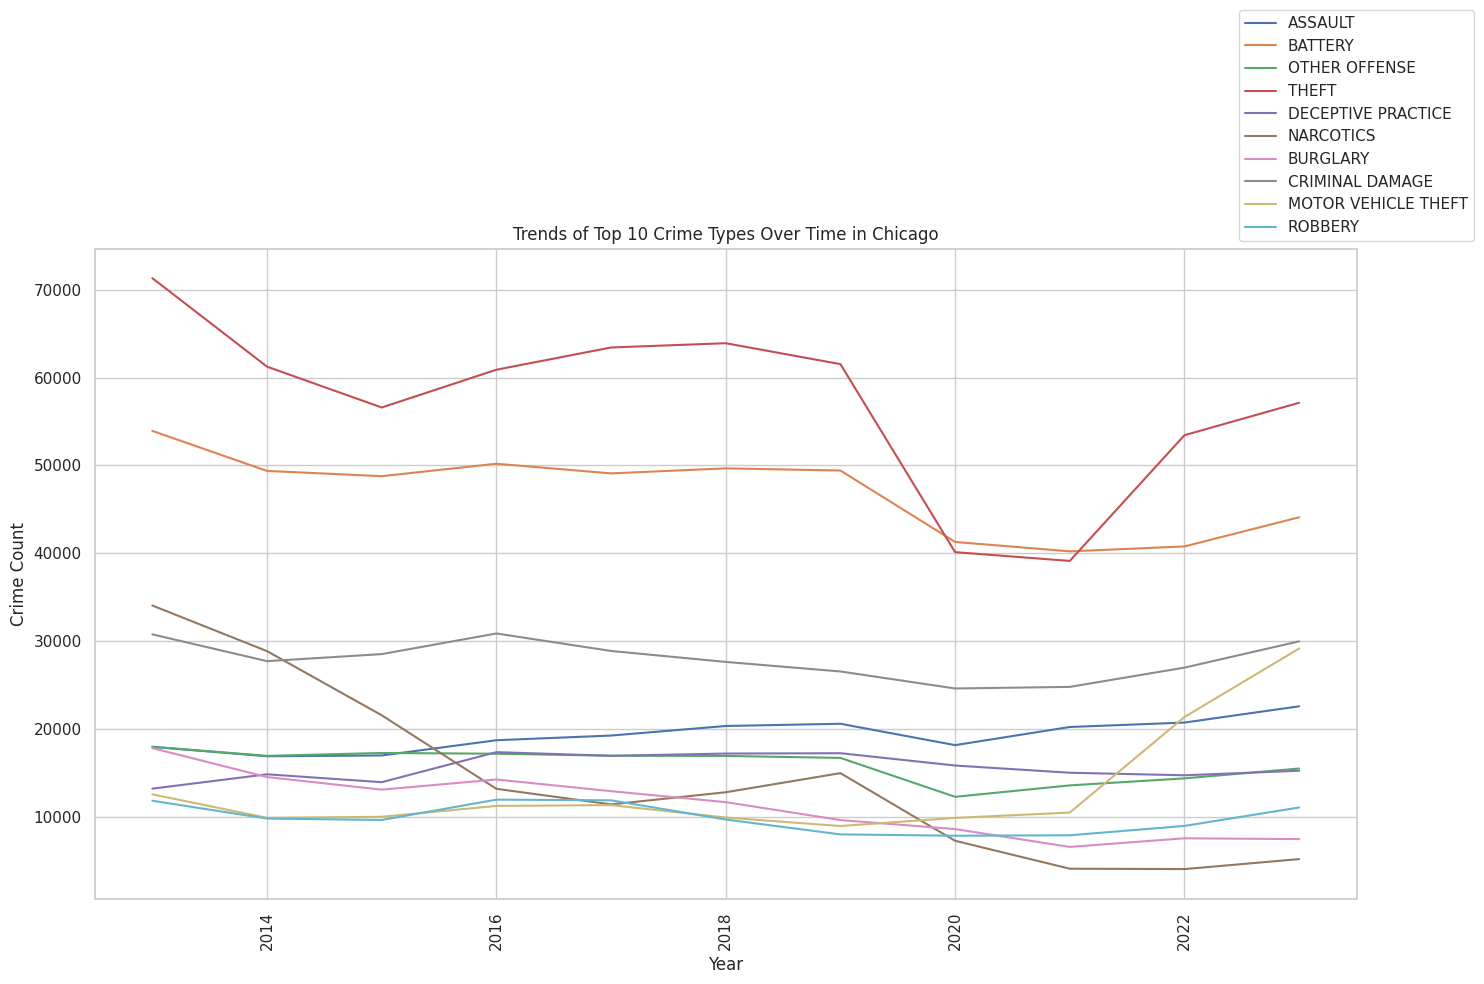

In [22]:
# Group by 'Primary Type' and 'Year', count the number of each type of crime
crime_type_year_counts = spark_df.groupBy('Primary Type', 'Year').count()

# Select the top 10 most common crime types
top_10_crime_types = crime_type_year_counts.groupBy('Primary Type') \
    .agg(F.sum('count').alias('total_count')) \
    .orderBy(F.desc('total_count')) \
    .limit(10) \
    .select('Primary Type')

# Filter the DataFrame to include only the top 10 crime types
top_10_crime_df = crime_type_year_counts.join(top_10_crime_types, 'Primary Type', 'inner')

# Convert Spark DataFrame to Pandas DataFrame for plotting with Seaborn
top_10_crime_pd = top_10_crime_df.toPandas()


plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")

for crime in top_10_crime_pd['Primary Type'].unique():
    crime_data = top_10_crime_pd[top_10_crime_pd['Primary Type'] == crime]
    sns.lineplot(x=crime_data['Year'], y=crime_data['count'], label=crime)

plt.title('Trends of Top 10 Crime Types Over Time in Chicago')
plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.xticks(rotation=90)
plt.legend(loc='lower center', bbox_to_anchor=(1,1)) 
plt.tight_layout()  
plt.show()


# Mapping Crimes by Area in Chicago
This map showcases the number of crimes by area. "Austin East" has the highest crime count, noticeably exceeding 1,60,000. "Near North Side" and "South Shore" follow, with numbers slightly above 1,20,000. In summary, while "Near North Side" stands out with the highest crime incidents, there's a general decrease as we move Upwards or Downwards, with a few areas showing significant deviations.

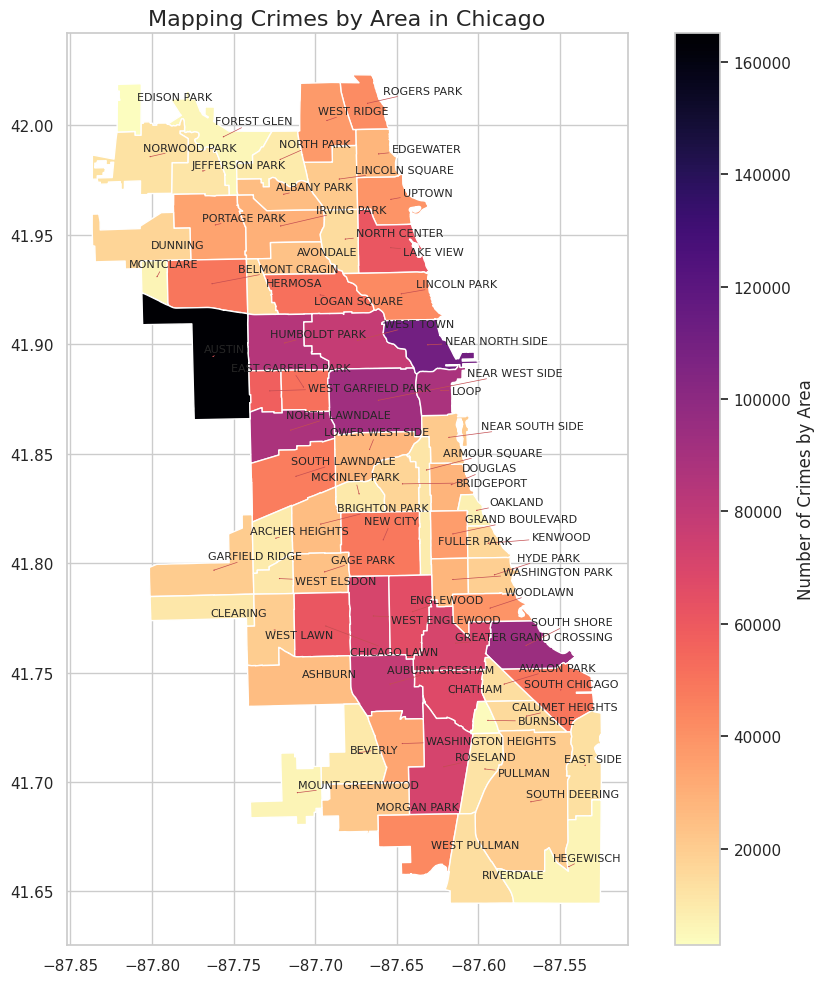

In [23]:
path = "/home/rnr/study/cmpe255/Final Project/rnr/chicago_boundaries.geojson"
gdf = gpd.read_file(path)
crime_counts = spark_df.groupBy('Community Area Name').agg(F.count('*').alias('crime_count'))

# Convert 'COMMUNITY_AREA_NAME' to uppercase
crime_counts = crime_counts.withColumn('Community Area Name', F.upper(F.col('Community Area Name'))).toPandas()
gdf_merged = gdf.merge(crime_counts, left_on='community', right_on='Community Area Name')


fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')  # Setting aspect ratio

gdf_merged.plot(column='crime_count', ax=ax, legend=True, cmap='magma_r',
                legend_kwds={'label': "Number of Crimes by Area"})

# Instead of annotating directly, gather all texts in a list
texts = []
for x, y, label in zip(gdf_merged.geometry.centroid.x, gdf_merged.geometry.centroid.y, gdf_merged['community']):
    texts.append(ax.text(x, y, label, fontsize=8))

# Use adjust_text to optimize text positions
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.title('Mapping Crimes by Area in Chicago', fontsize=16)
plt.tight_layout()
plt.show()


# Number of Crimes by Day of the Week in Chicago
The chart shows the "Number of Crimes by Day of the Week." Crimes are fairly consistent daily, with slight peaks on Friday and a modest dip on Sunday. This uniformity suggests crimes occur regularly, irrespective of the day. Further investigation might reveal factors influencing this near-even distribution.

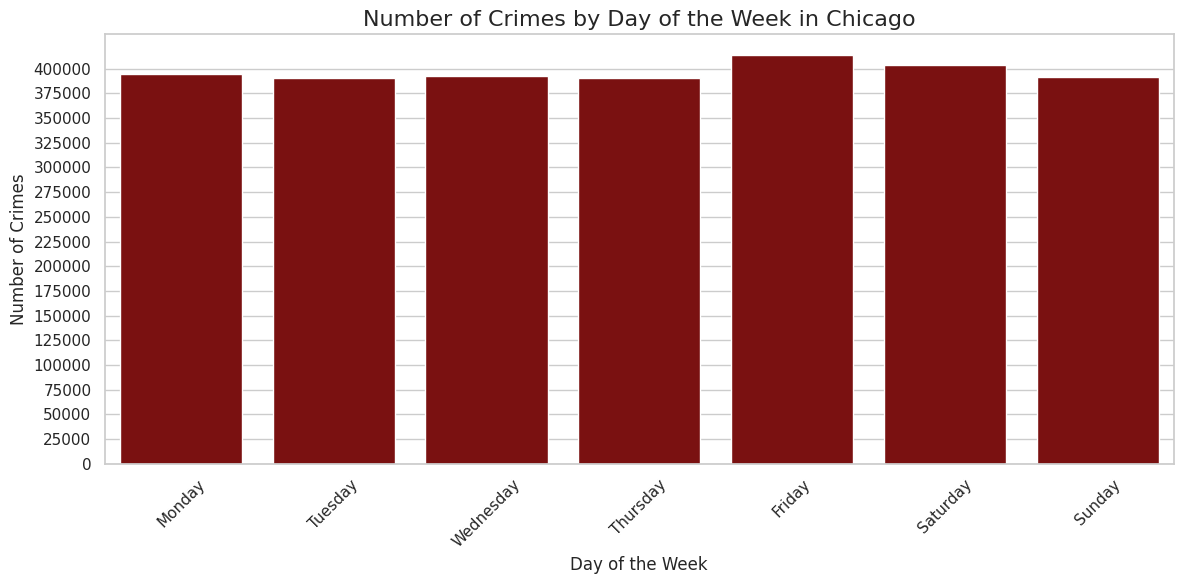

In [24]:
# Group by the day of the week and count the number of crimes
weekday_counts = spark_df.groupBy('day_of_week').count().withColumnRenamed('count', 'crime_count')

# Define the order of days for proper plotting
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert Spark DataFrame to Pandas DataFrame for plotting
weekday_counts_pd = weekday_counts.toPandas()

# Reorder the days for proper plotting
weekday_counts_pd['day_of_week'] = pd.Categorical(weekday_counts_pd['day_of_week'], categories=order, ordered=True)
weekday_counts_pd = weekday_counts_pd.sort_values('day_of_week')

# Visualize using a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='crime_count', data=weekday_counts_pd, color='darkred', order=order)
plt.title('Number of Crimes by Day of the Week in Chicago', fontsize=16)
plt.ylabel('Number of Crimes')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.yticks(range(0, max(weekday_counts_pd['crime_count']) + 1, 25000))
plt.tight_layout()
#plt.savefig('Crimes by Day.jpg', bbox_inches='tight')
plt.show()

# Distribution of Crimes by Hour of the Day in Chicago
The chart depicts "Distribution of Crimes by Hour of the Day." Crime occurrences dip in the early hours, rise steadily through the morning, peak around midday, then maintain a high plateau in the afternoon and evening.

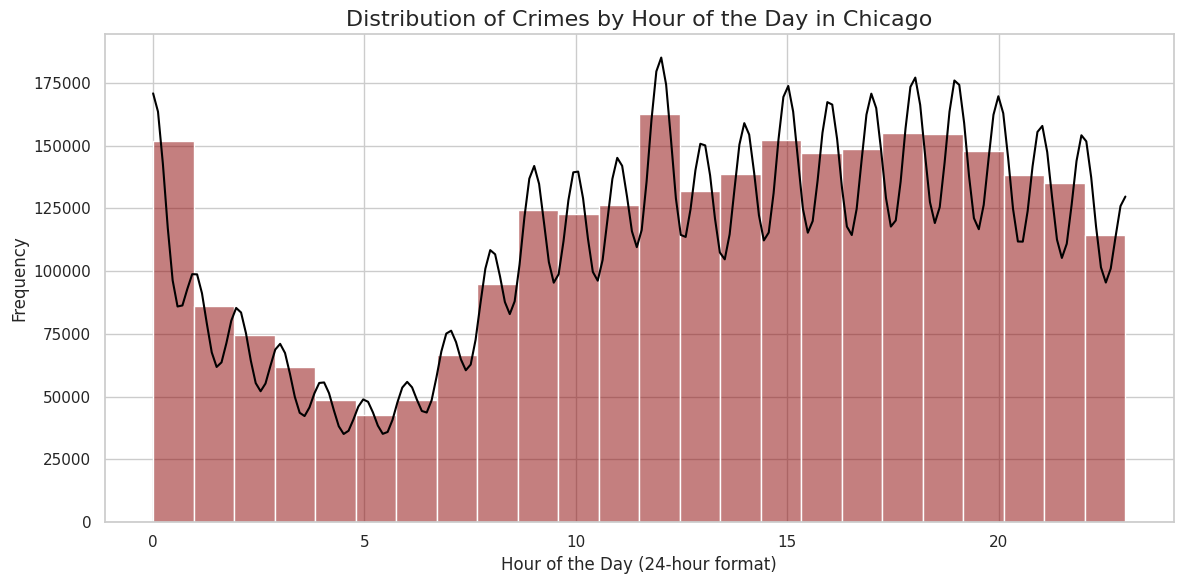

In [25]:
# Convert Spark DataFrame column to Pandas DataFrame or Series
hour_data = spark_df.select('hour').toPandas()['hour']

# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.histplot(hour_data, bins=24, kde=True, color='darkred').lines[0].set_color('black')

plt.title('Distribution of Crimes by Hour of the Day in Chicago', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [26]:
# Stop SparkSession
spark.stop()